In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd,requests,bs4,re,time,io,pytesseract,easyocr,random
from pdfminer.high_level import extract_text
from PIL import Image
from pathlib import Path
from pdf2image import convert_from_path
from selenium.webdriver.common.by import By
from goose3 import Goose
from datetime import datetime
from bs4 import BeautifulSoup
from selenium import webdriver

reader = easyocr.Reader(['en'])

import warnings
warnings.filterwarnings("ignore")

%autosave 1

D:\Anaconda\envs\gpu_16march2022\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Autosaving every 1 seconds


In [2]:
#driver for operation
from webdriver_manager.chrome import ChromeDriverManager
option = webdriver.ChromeOptions()
# option.add_argument('headless')
driver = webdriver.Chrome(ChromeDriverManager().install(),options=option)



====== WebDriver manager ======
Current google-chrome version is 102.0.5005
Get LATEST chromedriver version for 102.0.5005 google-chrome
Driver [C:\Users\AKSHAY SATPUTE\.wdm\drivers\chromedriver\win32\102.0.5005.61\chromedriver.exe] found in cache


In [3]:
SITE_NAME='Astellas'

DOMAIN = "https://www.astellas.com"

SITE_LINK="https://www.astellas.com/en/news"

In [4]:
def remove_esc_chars(text):
    return text.replace("\n", " ").replace("\t", " ").replace("\r", " ")

def get_text(link):
    g = Goose()
    article_extract = g.extract(url=link)
    article = remove_esc_chars(article_extract.cleaned_text)
    meta_data = remove_esc_chars(article_extract.meta_description)
    whole_data = meta_data+article
    text = whole_data.strip()
    
    if len(text) < 10:
        try:
            response = requests.get(link)
            text = remove_esc_chars(extract_text(io.BytesIO(response.content)))

            if len(text) < 10:
                texts = ""
                r = requests.get(link)
                filename = Path('temp.pdf')
                filename.write_bytes(r.content)

                pages = convert_from_path('temp.pdf', 500)
                for x in pages:
                    x.save("temp.jpg")
                    output = reader.readtext("temp.jpg")
                    for o in output:
                        texts += o[1]

                text = remove_esc_chars(texts)
        except:
            text = ""
    
    return text

In [5]:
def get_text_whn_cookies(link):
    retry_count = 3
    text = get_text(link)
    
    if re.findall("Why have I been blocked?",text): 
       
        while retry_count >0:
            driver.get(link)
            try:
                if True:
                    driver.find_element_by_xpath('''/html/body/div/div/div/section/div/div[1]/div/div[2]''').click()
            except:
                pass
            ps = driver.find_elements_by_tag_name("p")
            texts = ""
            for p in ps:
                texts +=p.text
            text = remove_esc_chars(texts).strip()
            if len(text) < 10:
                retry_count -= 1
                time.sleep(10)
            else:
                break
                
    if retry_count == 0:
        text = ""
                
    return text

In [6]:
article_list = []
pagination = 0
last_page = 2 #250

while pagination <= last_page:
    url = f"https://www.astellas.com/en/news?tab=latest&page={pagination}"
    driver.get(url)
    if pagination == 0:
        driver.find_element_by_xpath('''/html/body/div/div/div/section/div/div[1]/div/div[2]''').click()
    latest = driver.find_element(By.ID,"latest")
    elements = latest.find_elements(By.CLASS_NAME,"views-row")
    
    titles,published_dates,links,thumbnails,authors,texts = [],[],[],[],[],[]
    
    for element in elements:
        title = element.find_element_by_class_name("views-field-field-title").text.strip()
        titles.append(title)
        
        published_date = element.find_element_by_class_name("views-field-field-release-date").text.strip()
        published_dates.append(published_date)
        
        link = element.find_element_by_tag_name("a").get_attribute('href')
        links.append(link)
        
        thumbnail = "https://www.astellas.com/system/files/2017-01/global.png"
        thumbnails.append(thumbnail)
        
        author = SITE_NAME
        authors.append(author)
    
    for link in links :
        texts.append(get_text_whn_cookies(link))
        
    zipped = list(zip(published_dates,titles,texts,links,thumbnails,authors))
    
    for published_date,title,text,link,thumbnail,author in zipped:
        article = (published_date.strip(),title.strip(),text.strip(),link.strip(),thumbnail.strip(),author.strip())
        article_list.append(article)
        print(published_date,title)

    pagination += 1
 

Jun 01, 2022 Astellas and GO Therapeutics Enter into Strategic Research and License Agreement to Develop Novel Antibodies for Immuno-Oncology
May 26, 2022 Posted Notice of Convocation of the 17th Term Annual Shareholders Meeting
May 20, 2022 Astellas Confirms Unfavorable District Court Decision in LEXISCAN® 0.4mg/mL U.S. Patent Trial
May 19, 2022 Astellas Analysis Shows No Evidence of Increased Risk of Cardiovascular Events or Mortality with Roxadustat Compared with Erythropoiesis-Stimulating Agents (ESAs) at 59th ERA Congress 2022
May 16, 2022 Astellas to Present New Research Further Supporting Roxadustat Safety in the Treatment of Symptomatic Anemia of Chronic Kidney Disease at 59th ERA Congress 2022
May 13, 2022 Astellas Highlights Data on Advanced and Rare Cancers during 2022 ASCO Annual Meeting and EHA 2022 Hybrid Congress
May 12, 2022 Notice Regarding Continuation of the Performance-linked Stock Compensation Scheme and Performance-linked Stock Delivery Scheme for the Domestic and

In [7]:
#zippling the list so that it'll form the tuple
temp_df = pd.DataFrame(article_list,columns=['date','title','article','url','thumbnail','author'])
temp_df

,date,title,article,url,thumbnail,author
0,"Jun 01, 2022",Astellas and GO Therapeutics Enter into Strate...,- Collaboration to Accelerate Next-Generation ...,https://www.astellas.com/en/news/25851,https://www.astellas.com/system/files/2017-01/...,Astellas
1,"May 26, 2022",Posted Notice of Convocation of the 17th Term ...,Follow us on social media,https://www.astellas.com/en/news/25841,https://www.astellas.com/system/files/2017-01/...,Astellas
2,"May 20, 2022",Astellas Confirms Unfavorable District Court D...,"TOKYO, May 20, 2022 – Astellas Pharma Inc. (TS...",https://www.astellas.com/en/news/25706,https://www.astellas.com/system/files/2017-01/...,Astellas
3,"May 19, 2022",Astellas Analysis Shows No Evidence of Increas...,Pooled Phase 3 data for anemia of CKD patients...,https://www.astellas.com/en/news/25831,https://www.astellas.com/system/files/2017-01/...,Astellas
4,"May 16, 2022",Astellas to Present New Research Further Suppo...,Three abstracts provide additional insights in...,https://www.astellas.com/en/news/25821,https://www.astellas.com/system/files/2017-01/...,Astellas
5,"May 13, 2022",Astellas Highlights Data on Advanced and Rare ...,Abstracts represent exciting research progress...,https://www.astellas.com/en/news/25816,https://www.astellas.com/system/files/2017-01/...,Astellas
6,"May 12, 2022",Notice Regarding Continuation of the Performan...,Press Release Notice Regarding Continuation ...,https://www.astellas.com/system/files/news/202...,https://www.astellas.com/system/files/2017-01/...,Astellas
7,"May 12, 2022",Notice Regarding Continuation of the Performan...,Press Release Notice Regarding Continuation ...,https://www.astellas.com/system/files/news/202...,https://www.astellas.com/system/files/2017-01/...,Astellas
8,"May 09, 2022",We renovated our recruitment site.,This phrase reflects our sincere hope.We belie...,https://www.astellas.com/en/news/25801,https://www.astellas.com/system/files/2017-01/...,Astellas
9,"May 09, 2022",We published a story: “Astellas DX Strategy Se...,The pharmaceutical industry handles vast amoun...,https://www.astellas.com/en/news/25796,https://www.astellas.com/system/files/2017-01/...,Astellas


May 09, 2022 We published a story: “Astellas DX Strategy Series Vol.1: Utilizing DX to Create and Maximize VALUE for Patients.”

Astellas https://www.astellas.com/en/news/25796


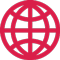


The pharmaceutical industry handles vast amounts of data throughout its entire value chain, from drug discovery (research), development, and manufacturing, to sales and the post-marketing maximization of our product value. Consulting firms have estimated that digital transformation (DX) will have a huge role to play in the information-intensive pharma industry. Conscious of the profound impact DX will have on the company's future, Astellas has selected DX as one of its critical enablers to create and deliver VALUE for patients and is driving forward initiatives on a global scale. Consultants analyzing the potential impact of DX on the pharmaceutical industry have highlighted huge benefits for drug R&D over the next 15 to20 years. These include the possibility of a 60% reduction in cost and a shortened timeframe of approximately 2.4 years*1 in drug research & development.*Source: “Paradigm of New Drug Discovery through Technology Advance” (Deloitte Tohmatsu Consulting LLC) “With advanc

In [8]:
def see_data(iloc_no=random.randint(0,len(temp_df))-1):
    print(temp_df.iloc[iloc_no]['date'],temp_df.iloc[iloc_no]['title'])
    print(f"\n{temp_df.iloc[iloc_no]['author']} {temp_df.iloc[iloc_no]['url']}")
    display(Image.open(io.BytesIO(requests.get(temp_df.iloc[iloc_no]['thumbnail']).content)))
    print(f"\n{temp_df.iloc[iloc_no]['article']}")

see_data()

In [9]:
#to csv
temp_df.to_csv(f'{SITE_NAME} news.csv',index = False)

#to json
temp_df.to_json(f'{SITE_NAME} news.json')

In [10]:
#to get rid of unwanteed trash created by the model use 
def remove_trash():
    try:
        os.remove("temp.jpg")
        os.remove("temp.pdf")
        print("Trash removed successfully")
    except:
        print("No trash found")

remove_trash()

No trash found
